# Segment Anything Model

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd '/content/gdrive/MyDrive/Speciale'

/content/gdrive/MyDrive/Speciale


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os

In [ ]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
#!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.2.1+cu121
Torchvision version: 0.17.1+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ln9b4f67
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ln9b4f67
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=108d0c64702c0e16d3125aa96397a41317165d10324d5c811f46587a54cd337e
  Stored in directory: /tmp/pip-ephem-wheel-cache-0bqn1pxz/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [ ]:
# define functions to show mask, point and bounding boks on the image
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [ ]:
# define checkpoints and predictor
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [ ]:
# load image
image_path = 'patches/DJI_0865_04.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

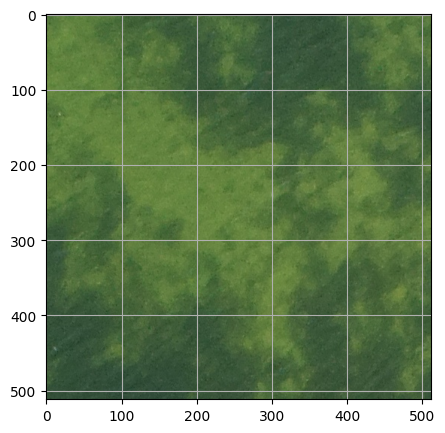

In [ ]:
# show image
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('on')
plt.grid()
plt.show()

In [ ]:
# Extract image embeddings
predictor.set_image(image)

In [ ]:
# define positive and negative points
input_point = np.array([[300,100],[50,400],[150,200],[450,480],[50,50],[350,50]])
input_label = np.array([1,1,0,1,0,1])

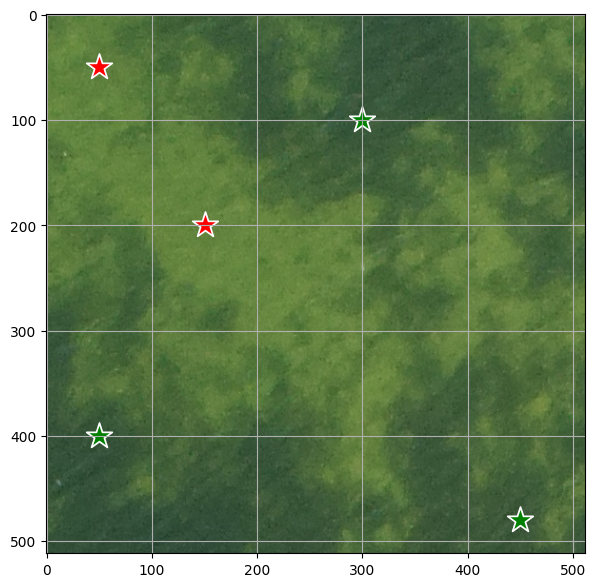

In [ ]:
# plot points on the image
plt.figure(figsize=(7,7))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.grid()
plt.show()

In [ ]:
# predict masks
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True, # True will create 3 masks with different scores
)

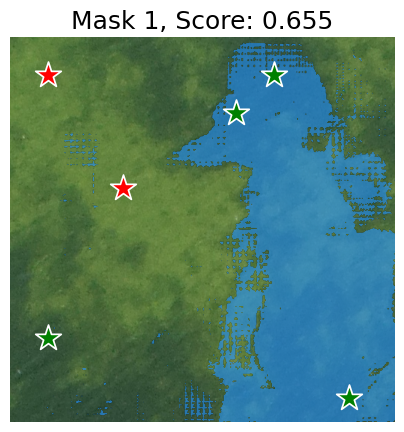

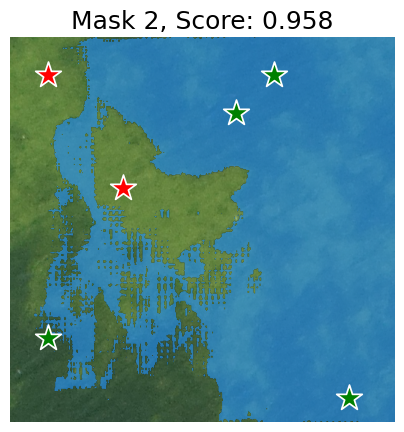

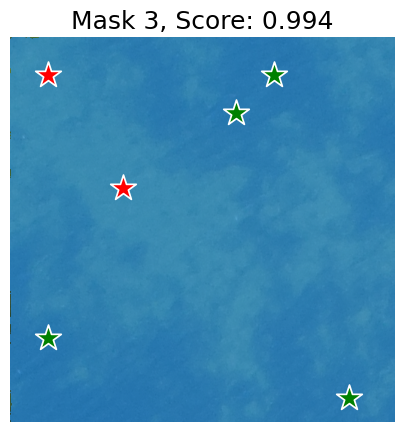

In [ ]:
# plot the masks and scores
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()

In [ ]:
# get the first mask

generated_mask = masks[0]
#print(generated_mask)

In [ ]:
# check the mask features

mask = generated_mask.astype(int)
#print(mask)
print(np.unique(mask))
mask.shape

[0 1]


(512, 512)

In [ ]:
# multiply to get the binary black and white mask
mask_255 = mask*255
print(np.unique(mask_255))

[  0 255]


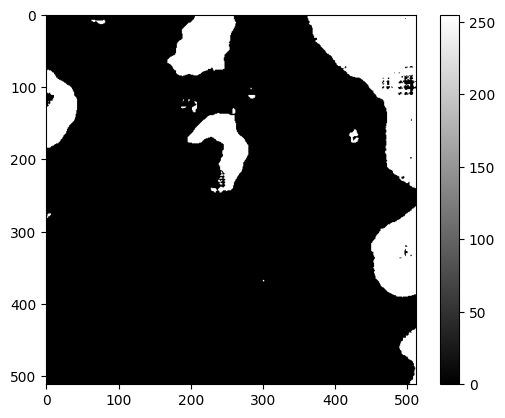

In [ ]:
# visualize the mask
plt.imshow(mask_255, cmap='gray')
plt.colorbar()  # Add a color bar
plt.show()

In [ ]:
# define folder to save masks
folder ='patches/'

# remove .jpg from file name
image_name = os.path.splitext(os.path.basename(image_path))[0]
print(image_name)

file_name = image_name + '_mask.jpg'
print(file_name)

# create file path and name
path = os.path.join(folder, file_name)
print(path)

# save to patch folder
if not cv2.imwrite(path, mask_255):
    raise Exception('Something is not working here')

DJI_0904_50
DJI_0904_50_mask.jpg
patches/DJI_0904_50_mask.jpg
